# GPU Memory Bandwidth Transpose Examples

In [1]:
using OpenCL
using CairoMakie
using Printf

In [2]:
BLOCK_SIZE = 16;

In [3]:
naive_transpose = "
__kernel void transpose(__global float *a_t,
                        __global float *a,
                        unsigned a_width,
                        unsigned a_height)
{
   int read_idx = get_global_id(0) + get_global_id(1) * a_width;
   int write_idx = get_global_id(1) + get_global_id(0) * a_height;
   a_t[write_idx] = a[read_idx];
}";

In [4]:
block_transpose = "
#define BLOCK_SIZE $(BLOCK_SIZE)
__kernel __attribute__((reqd_work_group_size(BLOCK_SIZE, BLOCK_SIZE, 1)))
void transpose(__global float *a_t, 
               __global float *a,
               unsigned a_width,
               unsigned a_height,
               __local float *a_local)
{
  int base_idx_a   = get_group_id(0) * BLOCK_SIZE + get_group_id(1) * (BLOCK_SIZE * a_width);
  int base_idx_a_t = get_group_id(1) * BLOCK_SIZE + get_group_id(0) * (BLOCK_SIZE * a_height);

  int glob_idx_a   = base_idx_a + get_local_id(0) + a_width * get_local_id(1);
  int glob_idx_a_t = base_idx_a_t + get_local_id(0) + a_height * get_local_id(1);

  a_local[get_local_id(1) * BLOCK_SIZE + get_local_id(0)] = a[glob_idx_a];

  barrier(CLK_LOCAL_MEM_FENCE);

  a_t[glob_idx_a_t] = a_local[get_local_id(0) * BLOCK_SIZE + get_local_id(1)];
}";

In [5]:
function enqueue_naive_kernel(k::cl.Kernel,
                              dst::CLArray{T},
                              src::CLArray{T},
                              dims) where {T}
    h, w = dims
    @assert w % BLOCK_SIZE == 0
    @assert h % BLOCK_SIZE == 0
    clcall(k, Tuple{Ptr{T}, Ptr{T}, Cuint, Cuint}, dst, src, h, w;
           global_size=(h,w), local_size=(BLOCK_SIZE,BLOCK_SIZE))
end

enqueue_naive_kernel (generic function with 1 method)

In [6]:
function enqueue_block_kernel(k::cl.Kernel,
                              dst::CLArray{T},
                              src::CLArray{T},
                              dims::Dims) where {T}
    h, w = dims
    @assert w % BLOCK_SIZE == 0
    @assert h % BLOCK_SIZE == 0
    lmem = cl.LocalMem(Float32, BLOCK_SIZE * (BLOCK_SIZE + 1))
    clcall(k, Tuple{Ptr{T}, Ptr{T}, Cuint, Cuint, CLPtr{Float32}}, dst, src, h, w, lmem;
           global_size=(h,w), local_size=(BLOCK_SIZE,BLOCK_SIZE))
end    

enqueue_block_kernel (generic function with 1 method)

In [7]:
function benchmark_transpose()    
    @assert cl.device().local_mem_size > 0
    
    prg  = cl.Program(source=naive_transpose) |> cl.build!
    naive_kern = cl.Kernel(prg, "transpose")
    
    prg = cl.Program(source=block_transpose)  |> cl.build!
    block_kernel = cl.Kernel(prg, "transpose")

    # use a command queue with profiling enabled
    cl.queue!(:profile) 
    
    array_sizes = [Int((2^i) / 32) * 32 for i in 6:12]

    mem_bandwiths = Float32[]
    for (name, method, kern) in (("naive", enqueue_naive_kernel, naive_kern), 
                                 ("block", enqueue_block_kernel, block_kernel))
        for s in array_sizes  
            src  = rand(Float32, (s, s))
            a_buf   = CLArray(src)
            a_t_buf = CLArray{Float32}(undef, length(src))
            
            # warm up....
            for i in 1:4
                method(kern, a_t_buf, a_buf, size(src))
            end
            
            # profile...
            count  = 20
            events = cl.Event[]
            for i in 1:count
                push!(events, method(kern, a_t_buf, a_buf, size(src)))
            end
            cl.wait(events[end])
            
            time = sum([evt.profile_duration for evt in events])
            mem_bw = 2 * sizeof(src) * count / (time * 1e-9)
            push!(mem_bandwiths, mem_bw)
            
            @printf("benchmarking %s, array size: %s^2, %.3f GB/s\n", name, s, mem_bw / 1e9)
            
        end
    end
    
    # plot results, sleep a little to prevent overlap with show..
    sleep(1)
    f = Figure()
    Axis(f[1, 1], title = "Transpose Tests for $(cl.device().name)", xlabel = "Matrix width/height N", ylabel = "Memory Bandwidth [GB/s]")
    n_sizes = length(array_sizes)
    naive_bandwidths = mem_bandwiths[1:n_sizes]
    block_bandwidths = mem_bandwiths[n_sizes+1:end]
    scatterlines!(array_sizes, naive_bandwidths/1e9, label="naive")
    scatterlines!(array_sizes, block_bandwidths/1e9, label="block")
    axislegend()
    f
end

benchmark_transpose (generic function with 1 method)

benchmarking naive, array size: 64^2, 1.410 GB/s
benchmarking naive, array size: 128^2, 4.858 GB/s
benchmarking naive, array size: 256^2, 9.095 GB/s
benchmarking naive, array size: 512^2, 11.412 GB/s
benchmarking naive, array size: 1024^2, 7.275 GB/s
benchmarking naive, array size: 2048^2, 21.517 GB/s
benchmarking naive, array size: 4096^2, 26.301 GB/s
benchmarking block, array size: 64^2, 4.720 GB/s
benchmarking block, array size: 128^2, 15.048 GB/s
benchmarking block, array size: 256^2, 37.555 GB/s
benchmarking block, array size: 512^2, 55.995 GB/s
benchmarking block, array size: 1024^2, 81.515 GB/s
benchmarking block, array size: 2048^2, 71.048 GB/s
benchmarking block, array size: 4096^2, 48.755 GB/s


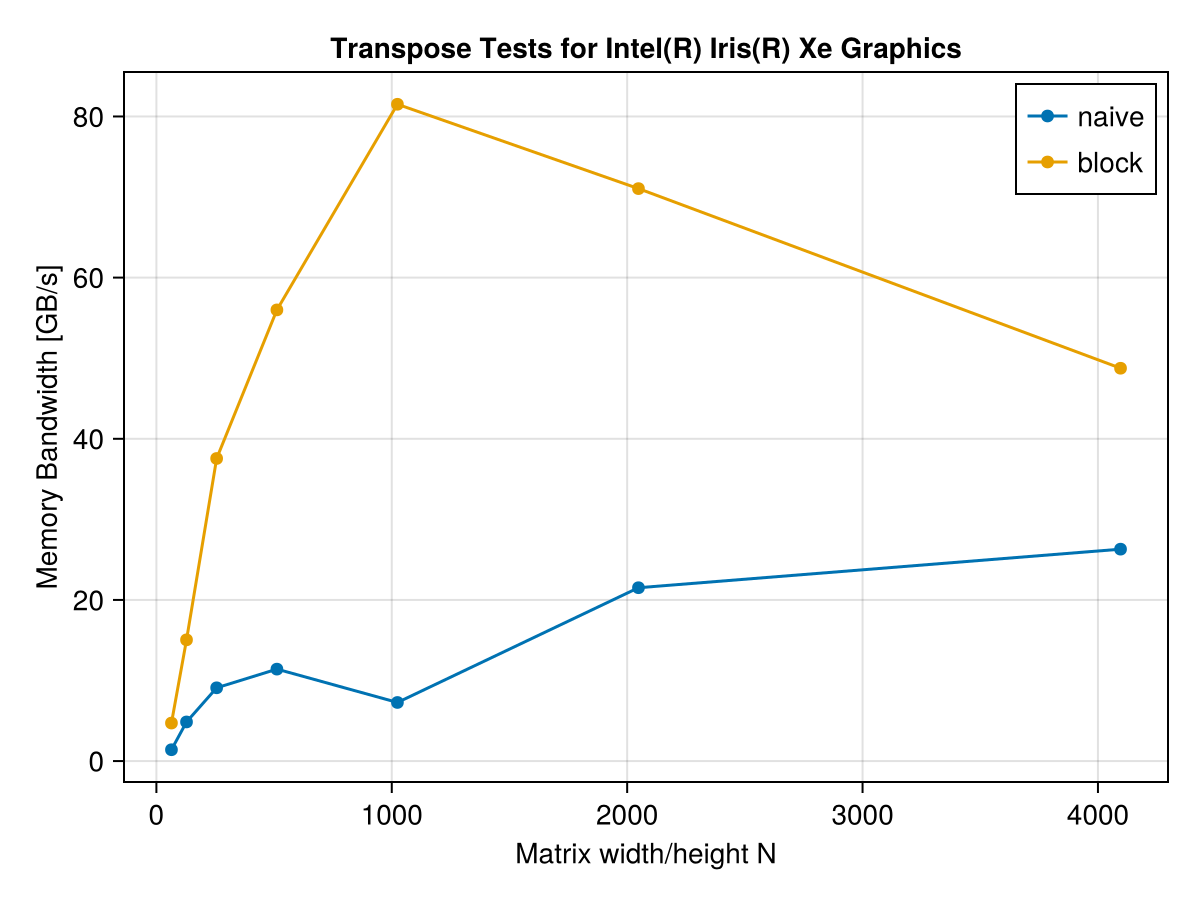

In [8]:
benchmark_transpose()